<Axes: >

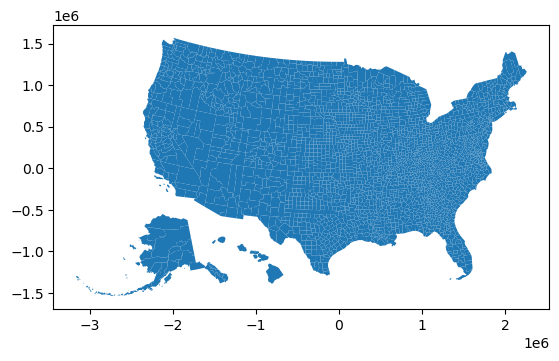

In [1]:
# generate plot by county
from pygris import counties
from pygris.utils import shift_geometry

analysis_year = 2017
us_counties = counties(year = analysis_year)
us_counties = shift_geometry(us_counties)
state_fips_to_drop = ['72', '78', '66', '69', '60']
us_counties = us_counties.loc[~us_counties['STATEFP'].isin(state_fips_to_drop)]
us_counties.plot()

In [2]:
# additional packages
from sklearn_extra.cluster import CLARA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np
from pandas import read_csv
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shapely.wkt
import geopandas as gpd
import contextily as cx
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

os.chdir('C:\SynthFirm')

In [3]:
# define scenario
scenario_name = 'national'
year_of_analysis = ['2019', '2020']
input_dir = 'inputs_' + scenario_name
# output_dirs = ['outputs_' + scenario_name + '_' + year for year in year_of_analysis]
plot_dir = 'plots_pandemic'
lehd_file = 'US_naics.csv'
map_file = scenario_name + '_freight.geojson'
# print(output_dirs)

['outputs_national_2019', 'outputs_national_2020']


In [4]:
region_map = gpd.read_file(os.path.join(input_dir, map_file))
mesozone_id_lookup = read_csv(os.path.join(input_dir, 'zonal_id_lookup_final.csv'))
lehd_validation = read_csv(os.path.join(input_dir, lehd_file))

output_dir_base = 'outputs_' + scenario_name + '_2019'
output_dir_disr = 'outputs_' + scenario_name + '_2020'


synthfirm_output_base = read_csv(os.path.join(output_dir_base, 'processed_b2b_flow_summary_mesozone.csv'))
print(len(synthfirm_output_base))
synthfirm_output_disruption = read_csv(os.path.join(output_dir_disr, 'processed_b2b_flow_summary_mesozone.csv'))
print(len(synthfirm_output_disruption))
synthfirm_output_base.head(5)

21675368
21524236


,Unnamed: 0,SellerZone,orig_FAFID,orig_FAFNAME,BuyerZone,dest_FAFID,dest_FAFNAME,Commodity_SCTG,SCTG_Group,SCTG_Name,mode_choice,tmiles,ShipmentLoad,count,outbound,inbound,Distance
0,0,10010202002,19,Rest of AL,10150008001,19,Rest of AL,5,3,interm_food,For-hire Truck,0.000000,0.019023,1,1,1,0.000000
1,1,10010202002,19,Rest of AL,10150008001,19,Rest of AL,5,3,interm_food,Private Truck,0.000000,0.019023,1,1,1,0.000000
2,2,10010202002,19,Rest of AL,10179540004,19,Rest of AL,5,3,interm_food,Private Truck,0.000000,0.050227,3,1,1,0.000000
3,3,10010202002,19,Rest of AL,10210601014,11,Birmingham,5,3,interm_food,For-hire Truck,15829.334237,0.123301,7,1,1,75.845859
4,4,10010202002,19,Rest of AL,10210601014,11,Birmingham,5,3,interm_food,Private Truck,11306.667312,0.088072,5,1,1,3.421668


In [23]:
print(synthfirm_output_base['ShipmentLoad'].sum())
print(synthfirm_output_disruption['ShipmentLoad'].sum())

13125688.470351014
12501934.084789021


In [6]:
# generate attributes needed by all sectors

# geoid +  land area
us_counties.loc[:, 'area'] = us_counties.loc[:, 'ALAND']/ 1000000 # in km^2
us_counties.loc[:, 'GEOID'] = us_counties.loc[:, 'GEOID'].astype(int)

us_county_df = pd.DataFrame(us_counties.drop(columns = 'geometry'))
us_county_df.head(5)

us_county_short_df = us_county_df[['GEOID', 'area']]

# spatial crosswalk
mesozone_to_county = mesozone_id_lookup[['MESOZONE', 'CBPZONE']]
mesozone_to_county.loc[:, 'MESOZONE'] = mesozone_to_county.loc[:, 'MESOZONE'].astype(np.int64)

In [ ]:
# define scenario naming system
scenario_prefix = {output_dir_base: 'base',
                  output_dir_disr: 'disruption'}

# Processing county-level data 

In [24]:
# production by county
def gen_comm_by_county(synthfirm_output, us_county_short_df, mesozone_to_county, zonal_id, col_attr, output_prefix):

    group_var = [zonal_id, col_attr]
    tonnage_in_region = synthfirm_output.groupby(group_var)[['ShipmentLoad']].sum()
    tonnage_in_region = tonnage_in_region.reset_index()
    tonnage_in_region = tonnage_in_region.rename(columns = {zonal_id: 'MESOZONE'})
    tonnage_in_region['MESOZONE'] = \
    tonnage_in_region['MESOZONE'].astype(np.int64)

    tonnage_by_county = pd.merge(tonnage_in_region, mesozone_to_county, 
                                   on = 'MESOZONE', how = 'left')

    col_groups = synthfirm_output[col_attr].unique().tolist()
    col_groups.append('total')
    
    tonnage_by_county = pd.pivot_table(tonnage_by_county, index = ['CBPZONE'],
                                          columns = col_attr, values = 'ShipmentLoad', aggfunc = 'sum')
    tonnage_by_county.loc[:, 'total'] = tonnage_by_county.sum(axis = 1)   
    tonnage_by_county = tonnage_by_county.reset_index()

    tonnage_by_county.loc[:, 'CBPZONE'] = tonnage_by_county.loc[:, 'CBPZONE'].astype(int)
    tonnage_by_county.rename(columns = {'CBPZONE': 'GEOID'}, inplace = True)


    tonnage_by_county = \
    pd.merge(us_county_short_df, tonnage_by_county, on='GEOID', how='left')
    tonnage_by_county.fillna(0, inplace = True)
    for attr in col_groups:
        attr_out = output_prefix + '_' + attr + '_per_area'
        tonnage_by_county.loc[:,attr_out] = \
        tonnage_by_county.loc[:, attr] * 0.907185/ \
        tonnage_by_county.loc[:, 'area']
    tonnage_by_county.drop(columns = col_groups, inplace = True)
    return(tonnage_by_county)      

production_by_county_base = \
                            gen_comm_by_county(synthfirm_output_base, us_county_short_df, 
                                               mesozone_to_county, 'SellerZone', 'SCTG_Name', 'base_prod')

production_by_county_disr = \
                            gen_comm_by_county(synthfirm_output_disruption, us_county_short_df, 
                                               mesozone_to_county, 'SellerZone', 'SCTG_Name', 'disruption_prod')  
production_by_county_base.head(5)                                    

,GEOID,area,base_prod_interm_food_per_area,base_prod_bulk_per_area,base_prod_mfr_goods_per_area,base_prod_fuel_fert_per_area,base_prod_other_per_area,base_prod_total_per_area
0,31039,1477.641638,1.503990,0.297090,0.000736,0.000000,0.0,1.801816
1,53069,680.956787,0.065886,0.008093,0.000000,0.000000,0.0,0.073979
2,35011,6016.761648,0.000285,0.008422,0.000034,0.000023,0.0,0.008764
3,31109,2169.252486,0.636496,0.056539,1.382690,0.034460,0.0,2.110185
4,31129,1489.645186,0.004067,0.319166,0.017557,0.000000,0.0,0.340791


In [37]:
consumption_by_county_base = \
                            gen_comm_by_county(synthfirm_output_base, us_county_short_df, 
                                               mesozone_to_county, 'BuyerZone', 'SCTG_Name', 'base_cons')

consumption_by_county_disr = \
                            gen_comm_by_county(synthfirm_output_disruption, us_county_short_df, 
                                               mesozone_to_county, 'BuyerZone', 'SCTG_Name', 'disruption_cons')  
consumption_by_county_base.head(5) 

,GEOID,area,base_cons_interm_food_per_area,base_cons_bulk_per_area,base_cons_mfr_goods_per_area,base_cons_fuel_fert_per_area,base_cons_other_per_area,base_cons_total_per_area
0,31039,1477.641638,1.325770,0.793387,0.088100,0.037779,0.000000,2.245037
1,53069,680.956787,0.049764,0.364075,0.031580,0.014904,0.198353,0.658676
2,35011,6016.761648,0.000720,0.000097,0.001361,0.003538,0.000000,0.005716
3,31109,2169.252486,3.279894,3.747820,1.656215,1.551276,0.106861,10.342066
4,31129,1489.645186,0.067658,0.183216,0.015374,0.034553,0.000000,0.300801


# Visualization of results

## base versus disruption

In [39]:


## base versus disruption

# select data for plotting commodity change 
upper_bound_abs = 20
upper_bound_diff = 2
# selected_scenario = 'baseline'
output_name_comp = 'delta_production_disruption'
 

production_change_comparison = pd.merge(production_by_county_base, 
                                     production_by_county_disr,
                                     on = ['GEOID', 'area'], how = 'left')

consumption_change_comparison = pd.merge(consumption_by_county_base, 
                                     consumption_by_county_disr,
                                     on = ['GEOID', 'area'], how = 'left')

col_groups = synthfirm_output_base['SCTG_Name'].unique().tolist()
col_groups.append('total')

prod_delta_attrs = []
prod_percent_attrs = []

cons_delta_attrs = []
cons_percent_attrs = []

for attr in col_groups:
    
    # production
    base_attr = 'base_prod_' + attr + '_per_area'
    alt_attr = 'disruption_prod_' + attr + '_per_area'
    delta_attr = 'delta_prod_' + attr + '_per_area'
    
    prod_delta_attrs.append(delta_attr)
    percent_delta_attr = 'percent_prod_' + attr + '_per_area'
    prod_percent_attrs.append(percent_delta_attr)
    
    production_change_comparison.loc[:, delta_attr] = \
    production_change_comparison.loc[:, alt_attr] -\
    production_change_comparison.loc[:, base_attr]
    
    production_change_comparison.loc[:, percent_delta_attr] = \
    production_change_comparison.loc[:, delta_attr] /\
    production_change_comparison.loc[:, base_attr]

    # consumption
    base_attr = 'base_cons_' + attr + '_per_area'
    alt_attr = 'disruption_cons_' + attr + '_per_area'
    delta_attr = 'delta_cons_' + attr + '_per_area'
    
    cons_delta_attrs.append(delta_attr)
    percent_delta_attr = 'percent_cons_' + attr + '_per_area'
    cons_percent_attrs.append(percent_delta_attr)
    
    consumption_change_comparison.loc[:, delta_attr] = \
    consumption_change_comparison.loc[:, alt_attr] -\
    consumption_change_comparison.loc[:, base_attr]
    
    consumption_change_comparison.loc[:, percent_delta_attr] = \
    consumption_change_comparison.loc[:, delta_attr] /\
    consumption_change_comparison.loc[:, base_attr]
    
    
production_change_comparison.fillna(0, inplace = True)
consumption_change_comparison.fillna(0, inplace = True)
production_change_comparison.loc[:, prod_percent_attrs] *= 100
consumption_change_comparison.loc[:, cons_percent_attrs] *= 100
# convert to percent
consumption_change_comparison.head(4)

,GEOID,area,base_cons_interm_food_per_area,base_cons_bulk_per_area,base_cons_mfr_goods_per_area,base_cons_fuel_fert_per_area,base_cons_other_per_area,base_cons_total_per_area,disruption_cons_interm_food_per_area,disruption_cons_bulk_per_area,...,delta_cons_bulk_per_area,percent_cons_bulk_per_area,delta_cons_mfr_goods_per_area,percent_cons_mfr_goods_per_area,delta_cons_fuel_fert_per_area,percent_cons_fuel_fert_per_area,delta_cons_other_per_area,percent_cons_other_per_area,delta_cons_total_per_area,percent_cons_total_per_area
0,31039,1477.641638,1.325770,0.793387,0.088100,0.037779,0.000000,2.245037,1.392140,0.789323,...,-0.004064,-0.512250,-0.003609,-4.096783,-0.002773,-7.338759,0.000000,0.00000,0.055924,2.491002
1,53069,680.956787,0.049764,0.364075,0.031580,0.014904,0.198353,0.658676,0.049057,0.352530,...,-0.011544,-3.170828,-0.000732,-2.319043,-0.002365,-15.865804,-0.198353,-100.00000,-0.213701,-32.444073
2,35011,6016.761648,0.000720,0.000097,0.001361,0.003538,0.000000,0.005716,0.000706,0.000093,...,-0.000004,-4.119870,-0.000032,-2.386870,-0.000060,-1.702171,0.000000,0.00000,-0.000111,-1.945596
3,31109,2169.252486,3.279894,3.747820,1.656215,1.551276,0.106861,10.342066,3.377026,3.747639,...,-0.000181,-0.004837,-0.058525,-3.533667,-0.136301,-8.786352,0.008441,7.89901,-0.089434,-0.864759


6.967626171126434


<Axes: >

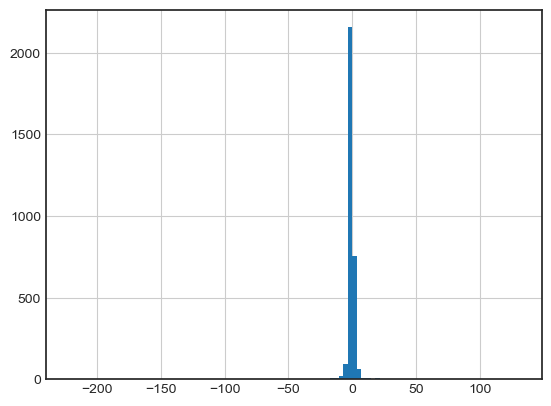

In [34]:
# percent_attrs
print(production_change_comparison['delta_prod_total_per_area'].quantile(0.99))
production_change_comparison['delta_prod_total_per_area'].hist(bins = 100)

plot difference for delta_prod_interm_food_per_area


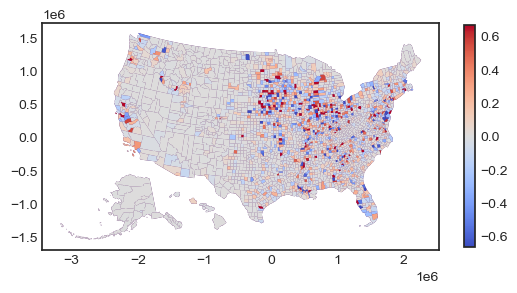

plot difference for delta_prod_bulk_per_area


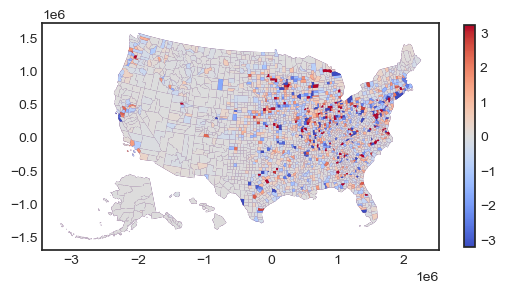

plot difference for delta_prod_mfr_goods_per_area


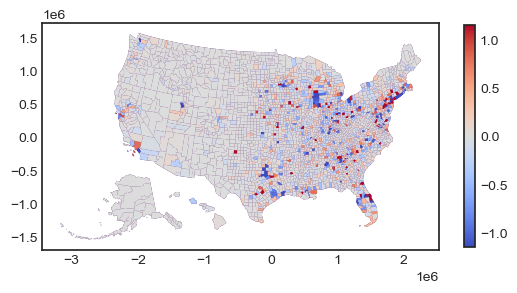

plot difference for delta_prod_fuel_fert_per_area


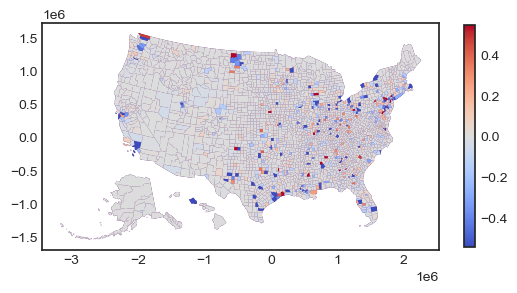

plot difference for delta_prod_other_per_area


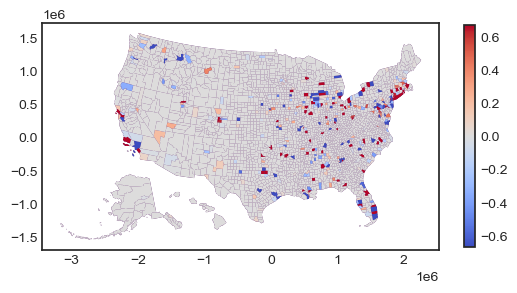

plot difference for delta_prod_total_per_area


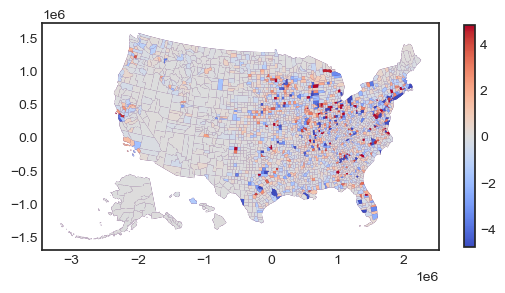

In [40]:
# plot absolute change in production

county_map_with_diff = us_counties.merge(production_change_comparison, on='GEOID', how='inner')


plt.style.use('seaborn-v0_8-white')
for fea in prod_delta_attrs:
    print('plot difference for ' + fea)
    ax = us_counties.plot( facecolor='#440154', linewidth = 0.01)
    upper_bound = county_map_with_diff[fea].quantile(0.975)
    lower_bound = county_map_with_diff[fea].quantile(0.025)
    upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
    lower_bound = -upper_bound
    county_map_with_diff.plot(figsize = (8,6), column = fea, 
                                legend=True,
                                  cmap='coolwarm', vmin = lower_bound, vmax = upper_bound, 
                                  linewidth=0.01,
                                legend_kwds = {'shrink': 0.6}, 
                                      edgecolor='none',ax = ax)
    

    ax.grid(False)
    # plt.title('Demand cluster')
    plt.savefig(os.path.join(plot_dir, 'county_' + fea + '.png'), dpi = 300, bbox_inches = 'tight')
    plt.show()

plot difference for delta_cons_interm_food_per_area


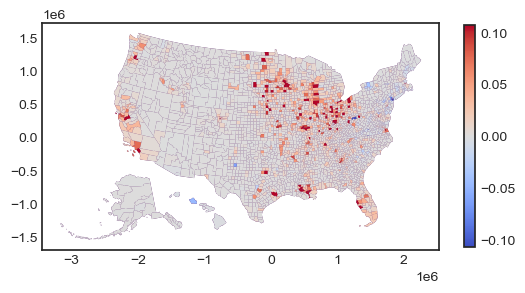

plot difference for delta_cons_bulk_per_area


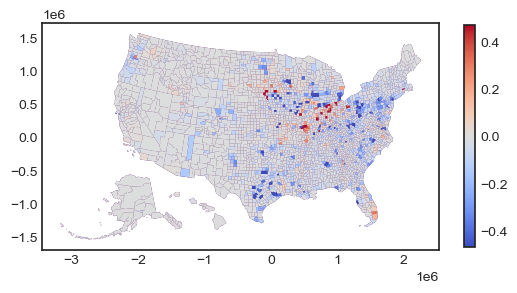

plot difference for delta_cons_mfr_goods_per_area


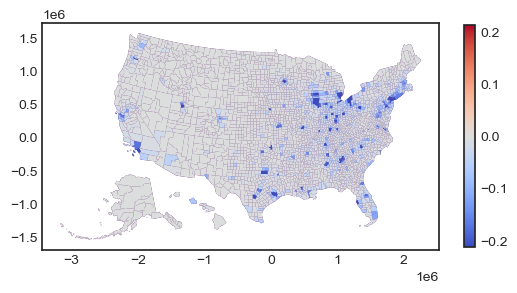

plot difference for delta_cons_fuel_fert_per_area


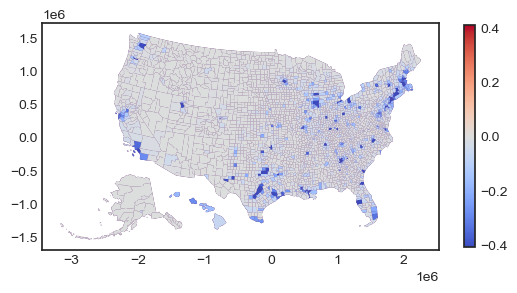

plot difference for delta_cons_other_per_area


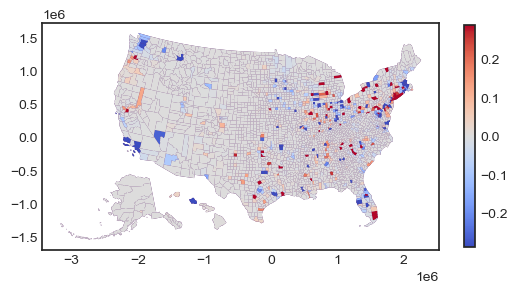

plot difference for delta_cons_total_per_area


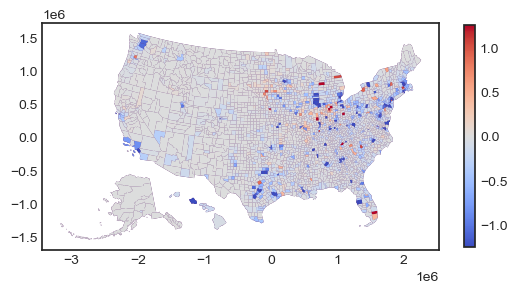

In [41]:
# plot absolute change in consumption

county_map_with_diff = us_counties.merge(consumption_change_comparison, on='GEOID', how='inner')


plt.style.use('seaborn-v0_8-white')
for fea in cons_delta_attrs:
    print('plot difference for ' + fea)
    ax = us_counties.plot( facecolor='#440154', linewidth = 0.01)
    upper_bound = county_map_with_diff[fea].quantile(0.975)
    lower_bound = county_map_with_diff[fea].quantile(0.025)
    upper_bound = max(abs(upper_bound), abs(lower_bound)) #symmetric +- range
    lower_bound = -upper_bound
    county_map_with_diff.plot(figsize = (8,6), column = fea, 
                                legend=True,
                                  cmap='coolwarm', vmin = lower_bound, vmax = upper_bound, 
                                  linewidth=0.01,
                                legend_kwds = {'shrink': 0.6}, 
                                      edgecolor='none',ax = ax)
    

    ax.grid(False)
    # plt.title('Demand cluster')
    plt.savefig(os.path.join(plot_dir, 'county_' + fea + '.png'), dpi = 300, bbox_inches = 'tight')
    plt.show()